### LG aimers 해커톤: 1주차 데이터 전처리
- 논문을 참고하자면 논문은 IVF 체외수정"만"을 처리함. 그래서 "DI 임신 횟수"와 같은 feature들이 포함되지 않음. 제공 받은 데이터에선 DI(체내수정) 그리고 특정 시술 유형으로 또 나눠지는 것을 볼 수가 있음. 
- 우선 먼저 첫번째로 시도 하는거니까 논문대로 "IVF만" 처리를 하고 있다. 그러므로  DI혹은 특정 시술 유형을 포함하여 전처리를 하는 방향으로 가야할 것 같음.     
=> 여기서 문제는 DI 방식일 경우 몇 개의 feature들("이식된 배아 수", "해동된 배아 수", "수집된 신선 난자 수", "파트너 정자와 혼합된 난자 수")은 "없음" 상태임. 이를 어떻게 해결할 것인가!
1. "없음" -> 0으로 치환한다.
2. Nan으로 유지하고 모델에서 처리 대신 로지스틱 회귀나 딥러닝 모델에선 다른 값으로 치환해야함. 이러면 나중에 정규화에서 문제가 생김.
3. IVF방식 따로, DI방식 따로 해서 합치기
     
✨일단 지은 결론: 1번    
- 대신 feature "시술 유형"을 추가해줌. DI를 0, IVF를 1로하고. DI에서 저 4개의 값을 "NaN"->0으로 치환. 그러면 "아 DI(0)일 경우엔 저 4개의 feature들이 비어있는건 당연한 것이구나"를 학습. 또한 DI와 관련있는 feature "DI 임신 횟수", "DI 출산 횟수" 포함.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
train = pd.read_csv(r"C:\Users\DELL\OneDrive\바탕 화면\학교\대학교 3학년\LG aimers\open\train.csv", encoding="utf-8")
test = pd.read_csv(r"C:\Users\DELL\OneDrive\바탕 화면\학교\대학교 3학년\LG aimers\open\test.csv", encoding="utf-8")

print(f"train: {train.shape}\ntest: {test.shape}")

train: (256351, 69)
test: (90067, 68)


In [ ]:
# DI 시술인 사람들 제외
#train = train[train['시술 유형'] == "IVF"]

# 나이가 "알 수 없음" 제외/ 하지 않고 범주(0~5)의 평균값으로 채우고자 함.
#train = train[train['시술 당시 나이'] != "알 수 없음"]

In [13]:
train.head()

,ID,시술 시기 코드,시술 당시 나이,임신 시도 또는 마지막 임신 경과 연수,시술 유형,특정 시술 유형,배란 자극 여부,배란 유도 유형,단일 배아 이식 여부,착상 전 유전 검사 사용 여부,...,기증 배아 사용 여부,대리모 여부,PGD 시술 여부,PGS 시술 여부,난자 채취 경과일,난자 해동 경과일,난자 혼합 경과일,배아 이식 경과일,배아 해동 경과일,임신 성공 여부
0,TRAIN_000000,TRZKPL,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0
1,TRAIN_000001,TRYBLT,만45-50세,NaN,IVF,ICSI,0,알 수 없음,0.0,NaN,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0
2,TRAIN_000002,TRVNRY,만18-34세,NaN,IVF,IVF,1,기록되지 않은 시행,0.0,NaN,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,2.0,NaN,0
3,TRAIN_000003,TRJXFG,만35-37세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0
4,TRAIN_000004,TRVNRY,만18-34세,NaN,IVF,ICSI,1,기록되지 않은 시행,0.0,NaN,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,3.0,NaN,0


- 69개의 feature 중, 논문에서 사용한건 30(5개는 논문에서 어떠한 이유로 제거 => 총 25)의 feature을 사용함.

- 이게 총 30개인데 여기서 ()한 5개는 제외 한다.

[시술 당시 나이, 총 시술 횟수, IVF 임신 횟수, IVF 출산 횟수,여성 주 불임 원인,여성 부 불임 원인,  남성 주 불임 원인, 남성 부 불임 원인, 부부 주 불임 원인, 부부 부 불임 원인, 불임 원인 - 난관 질환, 불임 원인 - 배란 장애, 불임 원인 - 남성 요인, 불명확 불임 원인,  불임 원인 - 자궁내막증, 불임 원인 - 자궁경부 문제, (불임 원인 - 여성 요인), 불임 원인 - 정자 농도, 불임 원인 - 정자 형태, 불임 원인 - 정자 운동성, (불임 원인 - 정자 면역학적 요인), (배란 자극 여부), (난자 출처), (정자 출처), 신선 배아 사용 여부, 동결 배아 사용 여부, 해동된 배아 수, 수집된 신선 난자 수, 파트너 정자와 혼합된 난자 수, 이식된 배아 수]

In [ ]:
# 통계적 정보 확인
train.describe()

In [14]:
selected_features=["시술 당시 나이", "시술 유형", "총 시술 횟수", "IVF 임신 횟수", "IVF 출산 횟수", "DI 임신 횟수", "DI 출산 횟수","여성 주 불임 원인", "여성 부 불임 원인",  "남성 주 불임 원인", "남성 부 불임 원인", "부부 주 불임 원인",
                    "부부 부 불임 원인", "불임 원인 - 난관 질환", "불임 원인 - 배란 장애", "불임 원인 - 남성 요인", "불명확 불임 원인",  "불임 원인 - 자궁내막증", "불임 원인 - 자궁경부 문제",
                    "불임 원인 - 정자 농도", "불임 원인 - 정자 형태", "불임 원인 - 정자 운동성", "신선 배아 사용 여부", "동결 배아 사용 여부", "해동된 배아 수", "수집된 신선 난자 수",
                    "파트너 정자와 혼합된 난자 수", "이식된 배아 수", "임신 성공 여부"]

# 필요한 feature 리스트 정의, "임신 성공 여부" = 타겟 변수로 70:30으로 나누어서 검증해야하기 때문에 포함시킴. 이후 x,y로 나눌 예정.
train= train[selected_features]
print(train.head())

  시술 당시 나이 시술 유형 총 시술 횟수 IVF 임신 횟수 IVF 출산 횟수 DI 임신 횟수 DI 출산 횟수  여성 주 불임 원인  \
0  만18-34세   IVF      0회        0회        0회       0회       0회           0   
1  만45-50세   IVF      0회        0회        0회       0회       0회           0   
2  만18-34세   IVF      1회        0회        0회       0회       0회           0   
3  만35-37세   IVF      1회        0회        0회       0회       0회           0   
4  만18-34세   IVF      0회        0회        0회       0회       0회           0   

   여성 부 불임 원인  남성 주 불임 원인  ...  불임 원인 - 정자 농도  불임 원인 - 정자 형태  불임 원인 - 정자 운동성  \
0           0           0  ...              0              0               0   
1           0           0  ...              0              0               0   
2           0           0  ...              0              0               0   
3           0           0  ...              0              0               0   
4           0           0  ...              0              0               0   

   신선 배아 사용 여부  동결 배아 사용 여부  해동된 배아 수  수집된 신선 난자 수

### 데이터 전처리
- 입력데이터 (x_train, x_val)를 정규화 또는 표준화 해야됨. 그 전에..
     
 1. ~회라고 적혀 있는 문자열 -> 숫자로 변환
 2. 정규화할지 표준화 할지...
 3. 나이 묶여있는 것도 숫자로 변환
 4. 일단 DI, 특정 유형 시술 신경쓰지 말기. -> 2차 할지 말지 여부는 성능 보고
 5. 정규화/표준화 -> 정규화 선택.
 6. IVF, DI 문자열 -> 레이블 인코딩

- 전처리는 훈련 데이터(x_train) 기준으로 학습하여 검증 데이터(x_val)에도 동일한 변환을 적용
---
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)  # 훈련 데이터로 스케일링 학습
x_val = scaler.transform(x_val)  # 동일한 변환 적용


In [24]:
# 4개의 feature의 최댓값 확인 => 아웃라이어 제거?
max_values = train[["이식된 배아 수", "해동된 배아 수", "수집된 신선 난자 수", "파트너 정자와 혼합된 난자 수"]].max()
print(max_values)


이식된 배아 수             3.0
해동된 배아 수            32.0
수집된 신선 난자 수         51.0
파트너 정자와 혼합된 난자 수    51.0
dtype: float64


C:\Users\DELL\AppData\Local\Temp\ipykernel_27272\3086976898.py:11: UserWarning: Glyph 54644 (\N{HANGUL SYLLABLE HAE}) missing from current font.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_27272\3086976898.py:11: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_27272\3086976898.py:11: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from current font.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_27272\3086976898.py:11: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from current font.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_27272\3086976898.py:11: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from current font.
  plt.tight_layout()
C:\Users\DELL\AppData\Local\Temp\ipykernel_27272\3086976898.py:11: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
C:\Us

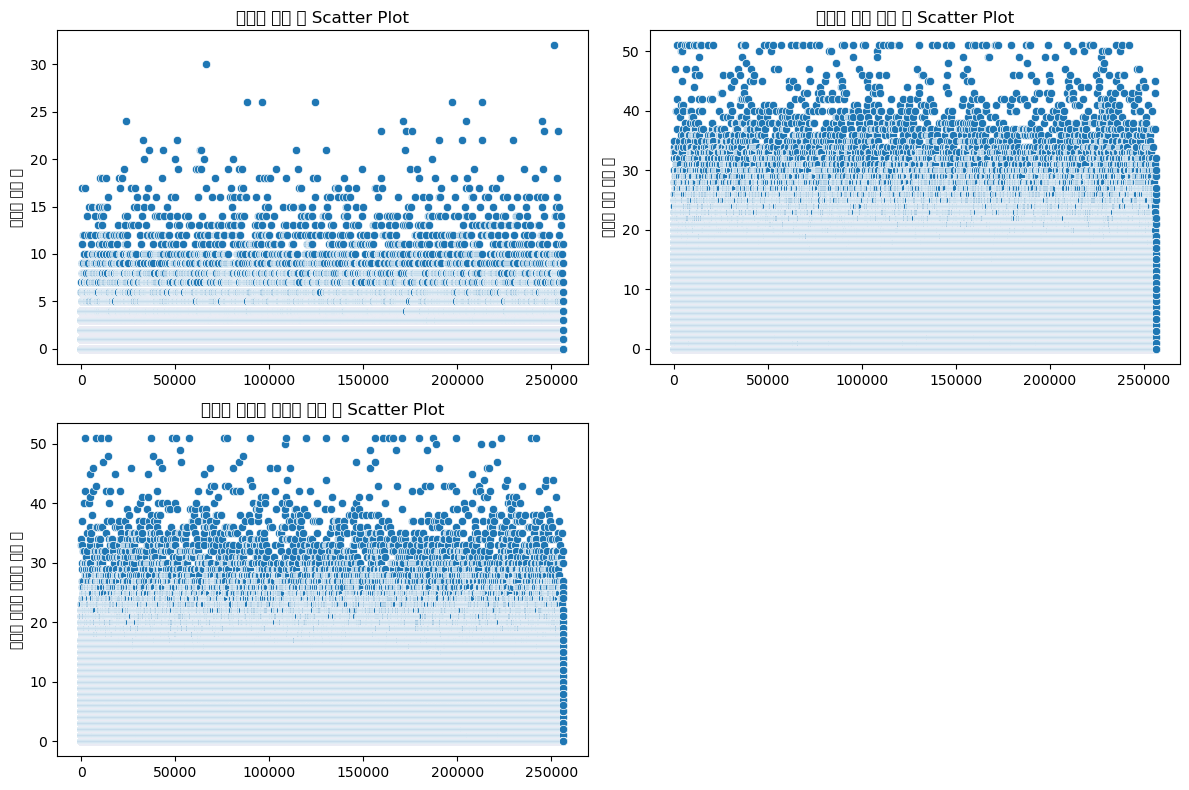

In [16]:
# 아웃라이어 확인할 feature들
features = [ "해동된 배아 수", "수집된 신선 난자 수", "파트너 정자와 혼합된 난자 수"]

# 시각화
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)  # 2x2 그리드로 배열
    sns.scatterplot(x=train.index, y=train[feature])
    plt.title(f'{feature} Scatter Plot')

plt.tight_layout()
plt.show()

# 해동된 배아수가 30 이상인 경우가 좀 걸리긴 하지만 일단 냅둠. 1차니까

In [ ]:
# 시술 유형 레이블 인코딩
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# '시술 유형' 컬럼을 0, 1로 변환
train['시술 유형'] = label_encoder.fit_transform(train['시술 유형'])
# IVF를 1으로, DI를 0로 변환

train.head()

,시술 당시 나이,시술 유형,총 시술 횟수,IVF 임신 횟수,IVF 출산 횟수,DI 임신 횟수,DI 출산 횟수,여성 주 불임 원인,여성 부 불임 원인,남성 주 불임 원인,...,불임 원인 - 정자 농도,불임 원인 - 정자 형태,불임 원인 - 정자 운동성,신선 배아 사용 여부,동결 배아 사용 여부,해동된 배아 수,수집된 신선 난자 수,파트너 정자와 혼합된 난자 수,이식된 배아 수,임신 성공 여부
0,만18-34세,1,0회,0회,0회,0회,0회,0,0,0,...,0,0,0,1.0,0.0,0.0,7.0,5.0,2.0,0
1,만45-50세,1,0회,0회,0회,0회,0회,0,0,0,...,0,0,0,1.0,0.0,0.0,1.0,1.0,0.0,0
2,만18-34세,1,1회,0회,0회,0회,0회,0,0,0,...,0,0,0,1.0,0.0,0.0,8.0,7.0,2.0,0
3,만35-37세,1,1회,0회,0회,0회,0회,0,0,0,...,0,0,0,1.0,0.0,0.0,5.0,4.0,0.0,0
4,만18-34세,1,0회,0회,0회,0회,0회,0,0,0,...,0,0,0,1.0,0.0,0.0,7.0,6.0,2.0,0


In [25]:
# DI인 경우, NaN인 feature들을 0으로 채우기
di_rows = train[train['시술 유형'] == 0]  # '시술 유형'에서 DI는 0으로 변환됨

# DI에서 NaN인 값들만 0으로 채우기
di_columns = ['해동된 배아 수', '수집된 신선 난자 수', '파트너 정자와 혼합된 난자 수', '이식된 배아 수', "신선 배아 사용 여부", "동결 배아 사용 여부"]
train.loc[train['시술 유형'] == 0, di_columns] = train.loc[train['시술 유형'] == 0, di_columns].fillna(0)

# 결과 확인
print(train.loc[train['시술 유형'] == 0, di_columns].isna().sum())  # NaN이 0으로 잘 채워졌는지 확인


해동된 배아 수            0
수집된 신선 난자 수         0
파트너 정자와 혼합된 난자 수    0
이식된 배아 수            0
신선 배아 사용 여부         0
동결 배아 사용 여부         0
dtype: int64


In [19]:
import numpy as np

# "시술 당시 나이" 변환 함수
def convert_age(age):
    if age == "만18-34세":
        return 0
    elif age == "만35-37세":
        return 1
    elif age == "만38-39세":
        return 2
    elif age == "만40-42세":
        return 3
    elif age == "만43-44세":
        return 4
    elif age == "만45-50세":
        return 5
    else:  # "알 수 없음"
        return np.nan  # "알 수 없음"을 NaN으로 처리

# Age 칼럼에 적용
train['시술 당시 나이'] = train['시술 당시 나이'].apply(convert_age)

# NaN 값을 평균값으로 채우기
mean_age = train['시술 당시 나이'].mean()  # 평균 계산
train['시술 당시 나이'].fillna(mean_age, inplace=True)  # NaN 값을 평균으로 대체


In [20]:
# 총 시술 횟수 변환
def convert_sting_to_num(count):
    if count == "0회":
        return 0
    elif count == "1회":
        return 1
    elif count == "2회":
        return 2
    elif count == "3회":
        return 3
    elif count == "4회":
        return 4
    elif count == "5회":
        return 5
    elif count == "6회 이상":
        return 6
    else:
        return None  # 알 수 없음 처리

# 총 시술 횟수 칼럼에 적용
train['총 시술 횟수'] = train['총 시술 횟수'].apply(convert_sting_to_num)

# IVF 임신 횟수 칼럼에 적용
train['IVF 임신 횟수'] = train['IVF 임신 횟수'].apply(convert_sting_to_num)

# IVF 출산 횟수 칼럼에 적용
train['IVF 출산 횟수'] = train['IVF 출산 횟수'].apply(convert_sting_to_num)

# DI 임신 횟수 칼럼에 적용
train['DI 임신 횟수'] = train['DI 임신 횟수'].apply(convert_sting_to_num)

# DI 출산 횟수 칼럼에 적용
train['DI 출산 횟수'] = train['DI 출산 횟수'].apply(convert_sting_to_num)

In [26]:
# 잘 변환된 것 확인.
print(train.head())

   시술 당시 나이  시술 유형  총 시술 횟수  IVF 임신 횟수  IVF 출산 횟수  DI 임신 횟수  DI 출산 횟수  \
0       0.0      1        0          0          0         0         0   
1       5.0      1        0          0          0         0         0   
2       0.0      1        1          0          0         0         0   
3       1.0      1        1          0          0         0         0   
4       0.0      1        0          0          0         0         0   

   여성 주 불임 원인  여성 부 불임 원인  남성 주 불임 원인  ...  불임 원인 - 정자 농도  불임 원인 - 정자 형태  \
0           0           0           0  ...              0              0   
1           0           0           0  ...              0              0   
2           0           0           0  ...              0              0   
3           0           0           0  ...              0              0   
4           0           0           0  ...              0              0   

   불임 원인 - 정자 운동성  신선 배아 사용 여부  동결 배아 사용 여부  해동된 배아 수  수집된 신선 난자 수  \
0               0          1.0    

In [ ]:
# 데이터 영어로 냅두지 걍
sns.heatmap(train.corr(), annot=True, cmap='coolwarm')

In [27]:
#결측치 수
train.isnull().sum()

# 신선/동결 배아 사용여부, 해동된 배아 수, 수집된 신선 난자 수, 파트너 정자와 혼합된 난자수, 이식된 배아 수 
# => DI 방식을 사용하였기 때문에 당연히 6291개의 값이 비어있음. = >0으로 넣어줌.

# 저 나이 빈건 어떻게 할 것인가... 일단 냅둬보고 좀있다가 좀 구리면 저거 나이 None인 것들 다 제거해야지.

시술 당시 나이            0
시술 유형               0
총 시술 횟수             0
IVF 임신 횟수           0
IVF 출산 횟수           0
DI 임신 횟수            0
DI 출산 횟수            0
여성 주 불임 원인          0
여성 부 불임 원인          0
남성 주 불임 원인          0
남성 부 불임 원인          0
부부 주 불임 원인          0
부부 부 불임 원인          0
불임 원인 - 난관 질환       0
불임 원인 - 배란 장애       0
불임 원인 - 남성 요인       0
불명확 불임 원인           0
불임 원인 - 자궁내막증       0
불임 원인 - 자궁경부 문제     0
불임 원인 - 정자 농도       0
불임 원인 - 정자 형태       0
불임 원인 - 정자 운동성      0
신선 배아 사용 여부         0
동결 배아 사용 여부         0
해동된 배아 수            0
수집된 신선 난자 수         0
파트너 정자와 혼합된 난자 수    0
이식된 배아 수            0
임신 성공 여부            0
dtype: int64

In [28]:
# 정규화.(0~1)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train[["시술 당시 나이", "IVF 임신 횟수", "IVF 출산 횟수", "DI 임신 횟수", "DI 출산 횟수"]] = scaler.fit_transform(train[["시술 당시 나이", "IVF 임신 횟수", "IVF 출산 횟수", "DI 임신 횟수", "DI 출산 횟수"]])
train[["이식된 배아 수", "해동된 배아 수", "수집된 신선 난자 수", "파트너 정자와 혼합된 난자 수"]] = scaler.fit_transform(train[["이식된 배아 수", "해동된 배아 수", "수집된 신선 난자 수", "파트너 정자와 혼합된 난자 수"]])


In [29]:
print(train.head())

   시술 당시 나이  시술 유형  총 시술 횟수  IVF 임신 횟수  IVF 출산 횟수  DI 임신 횟수  DI 출산 횟수  \
0       0.0      1        0        0.0        0.0       0.0       0.0   
1       1.0      1        0        0.0        0.0       0.0       0.0   
2       0.0      1        1        0.0        0.0       0.0       0.0   
3       0.2      1        1        0.0        0.0       0.0       0.0   
4       0.0      1        0        0.0        0.0       0.0       0.0   

   여성 주 불임 원인  여성 부 불임 원인  남성 주 불임 원인  ...  불임 원인 - 정자 농도  불임 원인 - 정자 형태  \
0           0           0           0  ...              0              0   
1           0           0           0  ...              0              0   
2           0           0           0  ...              0              0   
3           0           0           0  ...              0              0   
4           0           0           0  ...              0              0   

   불임 원인 - 정자 운동성  신선 배아 사용 여부  동결 배아 사용 여부  해동된 배아 수  수집된 신선 난자 수  \
0               0          1.0    

### 훈련 데이터와 검증 데이터 나누기
- 훈련:검증=7:3으로 나누어서 진행

In [30]:
# 입력 데이터(x)와 타겟 데이터(y) 분리
x = train.drop(columns=["임신 성공 여부"])
y = train["임신 성공 여부"]

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.3, random_state=42, stratify=y  # 0.3 = 30%를 검증에 이용하겠다.
)
# x_train: 훈련용 입력값 데이터, outcome 제외한 feature
# x_val: 검증용 입력값 데이터, outcome 제외한 feature
# y_train: 훈련용 타겟값=답(임신 성공 여부)
# y_val: 검증용 타겟값

In [31]:
print("훈련 데이터 크기:", x_train.shape, y_train.shape)
print("검증 데이터 크기:", x_val.shape, y_val.shape)

훈련 데이터 크기: (179445, 28) (179445,)
검증 데이터 크기: (76906, 28) (76906,)


In [ ]:
# 14번째 줄 확인 (인덱스는 0부터 시작하므로 13번째 인덱스)
print(train.iloc[


    
])


시술 당시 나이            0.800000
시술 유형               1.000000
총 시술 횟수             2.000000
IVF 임신 횟수           0.000000
IVF 출산 횟수           0.000000
DI 임신 횟수            0.000000
DI 출산 횟수            0.000000
여성 주 불임 원인          0.000000
여성 부 불임 원인          0.000000
남성 주 불임 원인          0.000000
남성 부 불임 원인          0.000000
부부 주 불임 원인          0.000000
부부 부 불임 원인          0.000000
불임 원인 - 난관 질환       0.000000
불임 원인 - 배란 장애       0.000000
불임 원인 - 남성 요인       1.000000
불명확 불임 원인           0.000000
불임 원인 - 자궁내막증       0.000000
불임 원인 - 자궁경부 문제     0.000000
불임 원인 - 정자 농도       0.000000
불임 원인 - 정자 형태       0.000000
불임 원인 - 정자 운동성      0.000000
신선 배아 사용 여부         1.000000
동결 배아 사용 여부         0.000000
해동된 배아 수            0.000000
수집된 신선 난자 수         0.058824
파트너 정자와 혼합된 난자 수    0.058824
이식된 배아 수            0.666667
임신 성공 여부            0.000000
Name: 15, dtype: float64


### 모델 훈련: 로지스틱 회귀, KNN, MLP, Decision Tree
- 다 진행

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# 모델 목록
models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "MLP": MLPClassifier(),
    "Decision Tree": DecisionTreeClassifier()
}

# 모델 학습 및 평가
for model_name, model in models.items():
    # 모델 훈련
    model.fit(x_train, y_train)
    
    # 예측
    y_pred = model.predict(x_val)
    
    # 평가
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Model: {model_name}")
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_val, y_pred))
    print("="*50)


c:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Accuracy: 0.7400592931630822
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.99      0.85     57037
           1       0.43      0.02      0.04     19869

    accuracy                           0.74     76906
   macro avg       0.59      0.50      0.44     76906
weighted avg       0.66      0.74      0.64     76906



c:\Users\DELL\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Model: KNN
Accuracy: 0.7030660806699087
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.87      0.81     57037
           1       0.38      0.23      0.29     19869

    accuracy                           0.70     76906
   macro avg       0.57      0.55      0.55     76906
weighted avg       0.66      0.70      0.68     76906

Model: MLP
Accuracy: 0.7409824981145814
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.99      0.85     57037
           1       0.48      0.03      0.06     19869

    accuracy                           0.74     76906
   macro avg       0.61      0.51      0.45     76906
weighted avg       0.68      0.74      0.65     76906

Model: Decision Tree
Accuracy: 0.6998933763295452
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.81     57037
           1       0.35      0.18  